เราจะมาลองเทรน 2 โมเดล เปรียบเทียบโมเดล ที่ใช้ Data Augmentation และไม่ใช้ ว่า Validation Loss จะต่างกันอย่างไร

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล



เราจะใช้ Dataset [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) จำแนกพันธุ์หมาแมวเหมือนดิม

In [3]:
path = untar_data(URLs.PETS)
path_images = path/'images'
filenames = get_image_files(path_images)

ประกาศฟัง์ชัน สร้าง databunch และฟังก์ชันแสดงภาพ

In [4]:
def get_databunch(transform):
    batchsize = 32
    np.random.seed(0)
    regex_pattern = r'/([^/]+)_\d+.jpg$'

    return ImageDataBunch.from_name_re(path_images, 
                                       filenames, 
                                       regex_pattern, 
                                       ds_tfms=transform, 
                                       size=224, bs=batchsize).normalize(imagenet_stats)

def get_ex(): return open_image(f'{path_images}/pug_147.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(transform[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

# 3. เตรียมข้อมูล

เราจะไปสร้าง DataBunch พร้อมสร้างโมเดลจะได้สะดวกในการเปรียบเทียบ

# 4. สร้างโมเดล



ในเคสนี้ เราจะใช้โมเดลที่ไม่ใหม่มาก ไม่มี Skip Connection อย่าง VGG และไม่ใช้ Dropout (ps=0.0), Weight Decay (wd=0.0) จะได้เปรียบเทียบได้ชัด ๆ

## No Data Augmentation
ปิด Data Augmentaion ทุกอย่าง

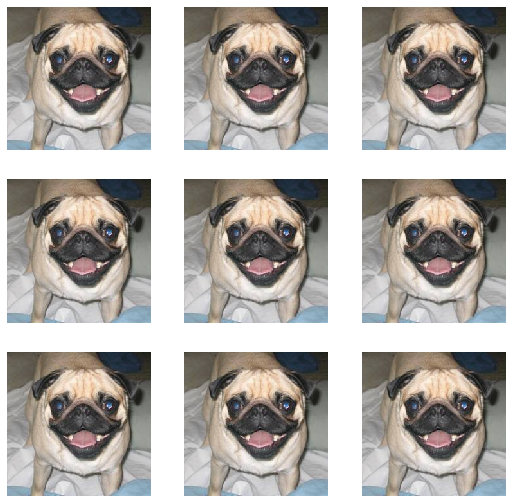

In [5]:
# transform = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0, max_zoom=1.0, max_lighting=0.0, max_warp=0.0, p_affine=0.0, p_lighting=0.0)
transform = zoom_crop(scale=(1.0,1.0), do_rand=False)
databunch = get_databunch(transform)
learner = cnn_learner(databunch, models.vgg16_bn, ps=0.0, wd=0.0, 
                      metrics=accuracy, callback_fns=ShowGraph).to_fp16()
plots_f(3, 3, 9, 9, size=224)

epoch,train_loss,valid_loss,accuracy,time
0,0.636092,0.367684,0.889716,01:54
1,0.374250,0.412772,0.870771,01:47
2,0.286406,0.824797,0.798376,01:47
3,0.170705,0.484501,0.879567,01:46
4,0.107457,0.638577,0.866712,01:46
5,0.076606,0.421747,0.907307,01:47
6,0.021379,0.443947,0.907307,01:46
7,0.011114,0.410848,0.908660,01:47
8,0.006526,0.418387,0.914750,01:46
9,0.002688,0.397952,0.919486,01:46


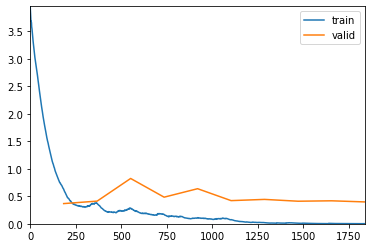

In [6]:
learner.unfreeze()
learner.fit_one_cycle(10, max_lr=slice(3e-6, 5e-3))

เคลียร์ Memory

In [7]:
learner = None
gc.collect()

23954

## Data Augmentation
เปิด Data Augmentaion ทุกอย่าง

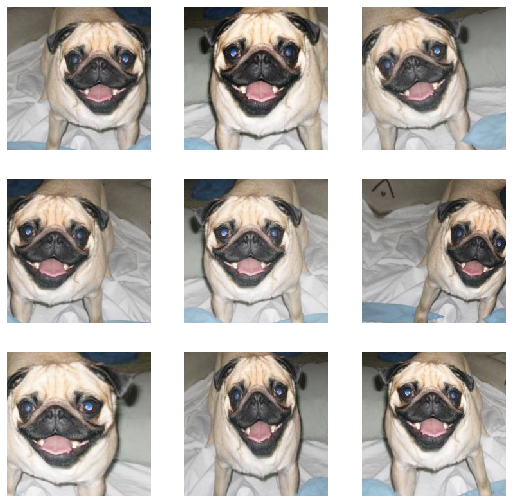

In [8]:
# transform = get_transform()
transform = get_transforms(do_flip=True, flip_vert=False, max_rotate=15.0, max_zoom=1.2, max_lighting=0.25, max_warp=0.25, p_affine=0.8, p_lighting=0.8)
databunch = get_databunch(transform)
learner = cnn_learner(databunch, models.vgg16_bn, ps=0.0, wd=0.0, 
                      metrics=accuracy, callback_fns=ShowGraph).to_fp16()
plots_f(3, 3, 9, 9, size=224)

epoch,train_loss,valid_loss,accuracy,time
0,0.721514,0.326159,0.901894,01:47
1,0.476856,0.369186,0.878890,01:47
2,0.430209,0.444615,0.866035,01:47
3,0.320537,0.367090,0.887010,01:47
4,0.219979,0.312151,0.915426,01:46
5,0.165850,0.306333,0.923545,01:47
6,0.100569,0.307241,0.926252,01:47
7,0.067798,0.283902,0.928958,01:47
8,0.035052,0.276090,0.930311,01:47
9,0.031696,0.267780,0.934371,01:46


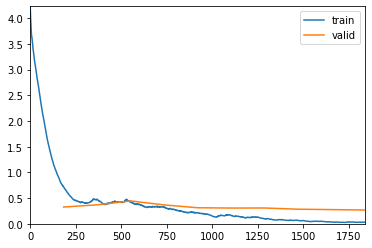

In [9]:
learner.unfreeze()
learner.fit_one_cycle(10, max_lr=slice(3e-6, 5e-3))

# 8. สรุป


1. โมเดลที่ไม่ได้ใช้ Data Augmentation เทรนไปหลาย Epoch แล้ว Training Loss ลดลงเรื่อย ๆ แต่ Validation Loss กลับเพิ่ม และ Accuracy ก็ไม่ได้ดีขึ้น เป็นสัญญาณของ Overfit 
2. โมเดลที่ใช้ Data Augmentation เทรนไปด้วยจำนวน Epoch เท่ากัน Training Loss ลดลงเรื่อย ๆ พร้อมกับ Validation Loss และ Accuracy ก็ดีขึ้นเรื่อย ๆ ไม่ Overfit
3. โมเดลสมัยใหม่ ออกแบบมาค่อนข้างดี ทำให้ Overfit ค่อนข้างยาก

# Credit 

* [Data Augmentation | How to use Deep Learning when you have Limited Data — Part 2](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
* [vision.transform](https://docs.fast.ai/vision.transform.html#get_transforms)
*  [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)
* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 1](https://course.fast.ai/videos/?lesson=1)
